<h1>1. Importing and Setting</h1>

In [1]:
# Import relevant libraries
import arcpy
from arcpy.sa import *  # Import the full Spatial Analyst module
import numpy as np  # To calculate PCT_90 (90th percentile) from flood depth raster
import geopandas as gpd  # To visualize vector layers
import pandas as pd  # To read and display CSV files 
import json  # To convert dictionary format to string 
# Set relevant settings
arcpy.env.workspace = r"C:\GisData\538_Output"  # Set the default workspace
arcpy.CheckOutExtension("Spatial")  # Enable the Spatial Analyst extension
arcpy.env.overwriteOutput = True  # Allow to overwrite files
arcpy.env.scratchWorkspace = r"C:\GisData\538_Scratch"  # Set the default location for temporary output data

# Root directory for original input datasets
input_dir = r"C:\GisData\538_Data\\"

<h1>2. Input Data Pre-processing</h1>

<h3>2.1. Decrease the DEM resolution from 1 meter to 10 meters</h3>

In [2]:
# Step 1: Define a variable that to store the path of the ADF-format DEM files
original_adf = input_dir + r"DEM_Hamilton\dem_hamilton"

# Step 2: Convert to TIF format
converted_tif = "converted_dem.tif"
arcpy.CopyRaster_management(original_adf, converted_tif)

# Step 3: Use the Resample method to decrease resolution to 10 meters
resampled_dem = "DEM_10m.tif"
arcpy.Resample_management(converted_tif, resampled_dem, "10", "BILINEAR")

<Result 'C:\\GisData\\538_Output\\DEM_10m.tif'>

<h3>2.2. Set the analysis area to Hamilton City</h3>

<AxesSubplot: >

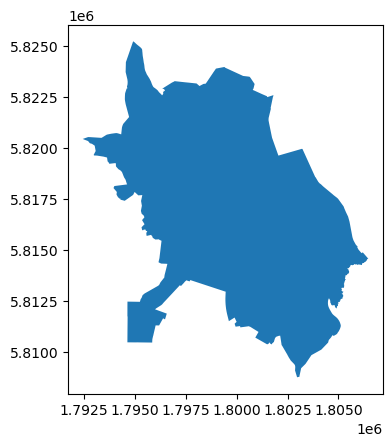

In [3]:
# Step 1: Define variables for the original and output (Hamilton City) shapefiles
original_shp = input_dir + r"territorial-authority\territorial-authority-2025-clipped"
hamilton_boundary = "HamiltonCity.shp"

# Step 2: Extract the Hamilton City Boundary from the original shapefile
arcpy.MakeFeatureLayer_management(original_shp, "temp_layer")  # Create a temporary layer for selecting specific features
arcpy.SelectLayerByAttribute_management("temp_layer", "NEW_SELECTION", "FID = 1")  # Select the feature with FID = 1, which represents the Hamilton City boundary
arcpy.CopyFeatures_management("temp_layer", hamilton_boundary)  # Export the selected feature and save it as a new shapefile 

# Step 3: Set the analysis mask and extent to the Hamilton City boundary 
arcpy.env.mask = hamilton_boundary
arcpy.env.extent = hamilton_boundary

# Step 4: Load and display the Hamilton City boundary shapefile
gdf = gpd.read_file(r"C:\GisData\538_Output\HamiltonCity.shp")
gdf.plot()

<h3>2.3. Clip DEM, soil, and landcover to the Hamilton City boundary</h3>

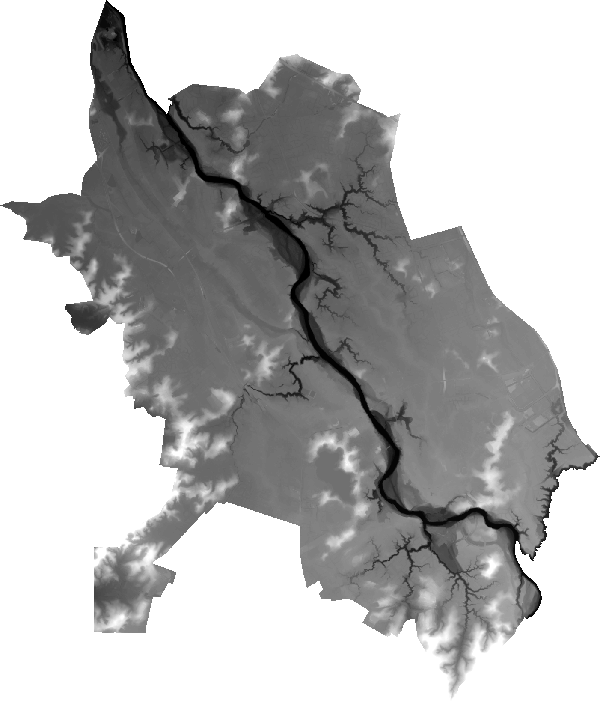

In [4]:
# Extract DEM to Hamilton City Boundary, and save it to disk
dem_clipped = ExtractByMask(resampled_dem, hamilton_boundary)
dem_clipped.save("clipped_DEM.tif")

# Set the analysis snap raster and cell size to match the extracted DEM
arcpy.env.snapRaster = dem_clipped
arcpy.env.cellSize = dem_clipped 

# Display the extracted DEM
dem_clipped

<AxesSubplot: >

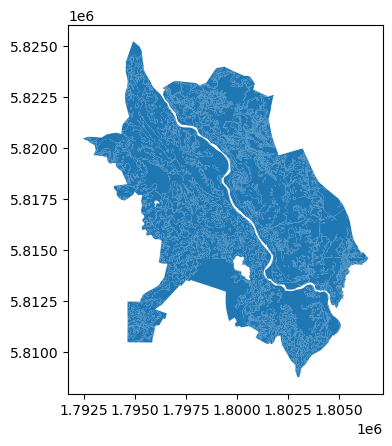

In [5]:
# Clip the soil shapefile to the Hamilton City boundary
original_soil = input_dir + r"Soil\soil.shp"
arcpy.Clip_analysis(original_soil, hamilton_boundary, "soil_clipped.shp")

# Load and display the clipped soil shapefile
gdf_soil = gpd.read_file(r"C:\GisData\538_Output\soil_clipped.shp")
gdf_soil.plot()

<AxesSubplot: >

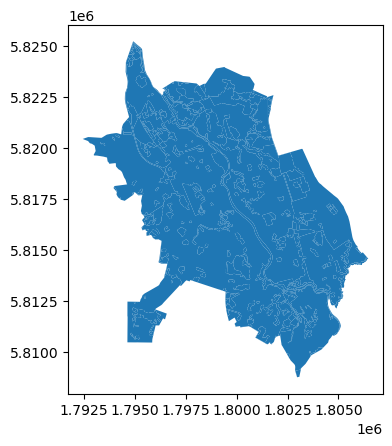

In [6]:
# Clip the landcover shapefile to the Hamilton City boundary
original_landcover = input_dir + r"Landcover\landcover.shp"
arcpy.Clip_analysis(original_landcover, hamilton_boundary, "landcover_clipped.shp")

# Load and display the clipped landcover shapefile
gdf_landcover = gpd.read_file(r"C:\GisData\538_Output\landcover_clipped.shp")
gdf_landcover.plot()

<h3>2.4 Create final weight layer from soil and landcover for flow accumulation</h3>

In [7]:
# Display the contents of the soil layer
display(gdf_soil)

,Drainage,geometry
0,Well drained,"POLYGON ((1800436 5820791, 1800446.58 5820773...."
1,Well drained,"POLYGON ((1800156.079 5822244.865, 1800153.939..."
2,Well drained,"POLYGON ((1800082.825 5822141.302, 1800076 582..."
3,Well drained,"POLYGON ((1799751.148 5822251.741, 1799753.586..."
4,Well drained,"POLYGON ((1799798.191 5821937.842, 1799803.538..."
...,...,...
1485,Poorly drained,"POLYGON ((1805235.964 5817165.35, 1805231.565 ..."
1486,Poorly drained,"POLYGON ((1805632.226 5815917.128, 1805660.485..."
1487,Poorly drained,"POLYGON ((1792921.33 5820317.252, 1792920.189 ..."
1488,Very poorly drained,"POLYGON ((1794362.908 5820873.82, 1794377.383 ..."


In [8]:
# Display the contents of the landcover layer
display(gdf_landcover)

,Name_2018,Name_2012,Name_2008,Name_2001,Name_1996,Class_2018,Class_2012,Class_2008,Class_2001,Class_1996,...,Wetland_96,Onshore_18,Onshore_12,Onshore_08,Onshore_01,Onshore_96,EditAuthor,EditDate,LCDB_UID,geometry
0,High Producing Exotic Grassland,High Producing Exotic Grassland,High Producing Exotic Grassland,High Producing Exotic Grassland,High Producing Exotic Grassland,40,40,40,40,40,...,no,yes,yes,yes,yes,yes,Landcare Research,2011-06-30,lcdb1000041468,"MULTIPOLYGON (((1802051.296 5819642.08, 180205..."
1,High Producing Exotic Grassland,High Producing Exotic Grassland,High Producing Exotic Grassland,High Producing Exotic Grassland,High Producing Exotic Grassland,40,40,40,40,40,...,no,yes,yes,yes,yes,yes,Landcare Research,2011-06-30,lcdb1000037140,"MULTIPOLYGON (((1803022.946 5808775.414, 18030..."
2,Built-up Area (settlement),Built-up Area (settlement),Built-up Area (settlement),High Producing Exotic Grassland,High Producing Exotic Grassland,1,1,1,40,40,...,no,yes,yes,yes,yes,yes,Landcare Research,2011-06-30,lcdb1000029786,"POLYGON ((1799628.44 5812040.12, 1799621.156 5..."
3,Urban Parkland/Open Space,Urban Parkland/Open Space,Urban Parkland/Open Space,Urban Parkland/Open Space,Urban Parkland/Open Space,2,2,2,2,2,...,no,yes,yes,yes,yes,yes,Regional Council,2011-06-30,lcdb1000006804,"POLYGON ((1799628.44 5812040.12, 1799622.036 5..."
4,Built-up Area (settlement),Built-up Area (settlement),Built-up Area (settlement),Built-up Area (settlement),High Producing Exotic Grassland,1,1,1,1,40,...,no,yes,yes,yes,yes,yes,Terralink,2004-06-30,lcdb1000028785,"POLYGON ((1799960.461 5811244.733, 1799953.429..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,Urban Parkland/Open Space,Urban Parkland/Open Space,Urban Parkland/Open Space,Urban Parkland/Open Space,Urban Parkland/Open Space,2,2,2,2,2,...,no,yes,yes,yes,yes,yes,Landcare Research,2019-12-01,lcdb1000005239,"POLYGON ((1804351.877 5814303.06, 1804353.413 ..."
386,Urban Parkland/Open Space,Urban Parkland/Open Space,Urban Parkland/Open Space,Urban Parkland/Open Space,Urban Parkland/Open Space,2,2,2,2,2,...,no,yes,yes,yes,yes,yes,Terralink,2004-06-30,lcdb1000005231,"POLYGON ((1804317.11 5813565.343, 1804231.995 ..."
387,Urban Parkland/Open Space,Urban Parkland/Open Space,Urban Parkland/Open Space,Urban Parkland/Open Space,Urban Parkland/Open Space,2,2,2,2,2,...,no,yes,yes,yes,yes,yes,Landcare Research,2019-12-01,lcdb1000005234,"POLYGON ((1804811.35 5813591.125, 1804768.394 ..."
388,Urban Parkland/Open Space,Urban Parkland/Open Space,Urban Parkland/Open Space,Urban Parkland/Open Space,Urban Parkland/Open Space,2,2,2,2,2,...,no,yes,yes,yes,yes,yes,Terralink,2004-06-30,lcdb1000005243,"POLYGON ((1804927.891 5814509.86, 1805038.822 ..."


In [9]:
# Step 1: Function that adds a new field to the shapefile and computes its values using the specified mapping dictionary
def add_and_calculate_field(shapefile, field_name, mapping_dict, target_field):
    
    # Parameters:
    # - shapefile: Path to the input shapefile
    # - field_name : Name of the new field to be added 
    # - mapping_dict: Dictionary mapping values in target_field to numeric codes
    # - target_field: The existing field whose values will be mapped

    # Define the expression used in CalculateField, look up the value corresponding to the target_field from the dictionary mapping
    expression = "mapping[!{}!]".format(target_field)

    # Convert the input mapping_dict dictionary to a string for use as the code_block of CalculateField
    code_block = f"mapping = {json.dumps(mapping_dict)}"
    
    # Add the new field to the shapefile
    arcpy.AddField_management(shapefile, field_name, "SHORT")

    # Calculate the new field's value by applying the mapping dictionary
    arcpy.CalculateField_management(
        in_table=shapefile,
        field=field_name,
        expression=expression,
        expression_type="PYTHON3",
        code_block=code_block
    )

In [10]:
# Step 2: Function that converts a polygon shapefile to a raster based on a value field
def vector_to_raster(in_features, value_field, out_raster, cellsize_ref):

    # Parameters:
    # - in_features: Path to the input polygon shapefile
    # - value_field: The field whose values will be used for raster cells
    # - out_raster: Path to the output raster file 
    # - cellsize_ref: Cell size or reference raster to match resolution

    # Convert the polygon shapefile to a raster
    # Each polygon will be assigned to raster cells using the specified value_field
    arcpy.PolygonToRaster_conversion(
        in_features=in_features,
        value_field=value_field,
        out_rasterdataset=out_raster,
        cell_assignment="MAXIMUM_AREA",
        cellsize=cellsize_ref
    )

    # Return the raster object
    return Raster(out_raster)

In [11]:
# Step 3: Function that reclassify a raster using a value-to-weight mapping list, and convert to float weight values
def reclassify_to_weight(raster, remap_list, out_path):

    # Parameters:
    # - raster: Input raster (landcover or soil raster)
    # - remap_list: Value remapping rules, e.g., [(1, 10), (2, 20), (3, 50)], and the input value will be reclassified to an integer weight                                
    # - out_path: Output path to save the reclassified float-weight raster

    # Create a RemapValue object from the remap_list
    remap = RemapValue(remap_list)

    # Reclassify the raster values using the remap rules (e.g., 1 → 10, 2 → 20)
    weight_int = Reclassify(raster, "Value", remap)

    # Convert the integer weights to float (e.g., 10 → 0.1)
    weight_float = weight_int / 100.0

    # Save the float-weight raster to disk
    weight_float.save(out_path)

    # Return the resulting weight Raster object
    return Raster(out_path)

In [12]:
# Step 4: Function that merge two weight rasters (soil and landcover) into a final weight raster
def merge_weights(soil_raster, landcover_raster, out_path):

    # Logic:
    # - If both rasters are NoData: assign 0.5 as default weight
    # - If one raster is NoData: use the other raster's value
    # - If both have values: calculate average of the two (equal weight)
    final_weight = Con(
        IsNull(soil_raster) | IsNull(landcover_raster),
        Con(
            IsNull(soil_raster),
            Con(
                IsNull(landcover_raster),
                0.5,
                landcover_raster
            ),
            soil_raster
        ),
        (soil_raster * 0.5 + landcover_raster * 0.5)
    )

    # Save the final weight layer to disk, and return it
    final_weight.save(out_path)
    return Raster(out_path)


In [13]:
# Step 5: Call the methods to generate the final weight layer

# 1. Process soil shapfile
# 1.1 Defines the mapping of soil drainage classes to integer codes (Checked the names in ArcGIS Pro)
soil_map = {
    "Well drained": 1,
    "Moderately well drained": 2,
    "Imperfectly drained": 3,    
    "Poorly drained": 4,  
    "Very poorly drained": 5
    }

# 1.2 Add values of "DrainCode"，and convert the Drainage field to interger 
add_and_calculate_field("soil_clipped.shp", "DrainCode", soil_map, "Drainage")

# 1.3 Convert soil shapefile to raster（based on the new values: DrainCode）
soil_ras = vector_to_raster("soil_clipped.shp", "DrainCode", "soil_raster.tif", "clipped_DEM.tif")

# 1.4 Reclassify integer raster weights to floating point
soil_weight = reclassify_to_weight(soil_ras, [[1, 20], [2, 30], [3, 50], [4, 60], [5, 100]], "soil_weight.tif") # The larger the weight → the worse the permeability

In [14]:
# 2. Process landcover shapfile
# 2.1 Defines the mapping of landcover classes to integer codes (Checked the names in ArcGIS Pro)
landcover_map = {
    "Lake or Pond": 1,
    "River": 1,
    "Indigenous Forest": 2,
    "Exotic Forest": 2,
    "Deciduous Hardwoods": 2,
    "Broadleaved Indigenous Hardwoods": 2,
    "High Producing Exotic Grassland": 3,
    "Low Producing Grassland": 3,
    "Short-rotation Cropland": 3,
    "Orchard, Vineyard or Other Perennial Crop": 3,
    "Urban Parkland/Open Space": 4,
    "Herbaceous Freshwater Vegetation": 4,
    "Transport Infrastructure": 4,
    "Built-up Area (settlement)": 5,
    "Surface Mine or Dump": 5,
    "Gorse and/or Broom": 4,
    "Manuka and/or Kanuka": 3
}

# 2.2 Add the field "LandCode" and map the code based on the "Name_2018" field
add_and_calculate_field("landcover_clipped.shp", "LandCode", landcover_map, "Name_2018")

# 2.3 Convert landcover shapefile to raster (value is LandCode)
landcover_ras = vector_to_raster("landcover_clipped.shp", "LandCode", "landcover_raster.tif", "clipped_DEM.tif")

# 2.4 Reclassify integer raster weights to floating point
landcover_weight = reclassify_to_weight(landcover_ras, [[1, 20], [2, 30], [3, 50], [4, 60], [5, 100]], "landcover_weight.tif") # The larger the weight → the worse the permeability

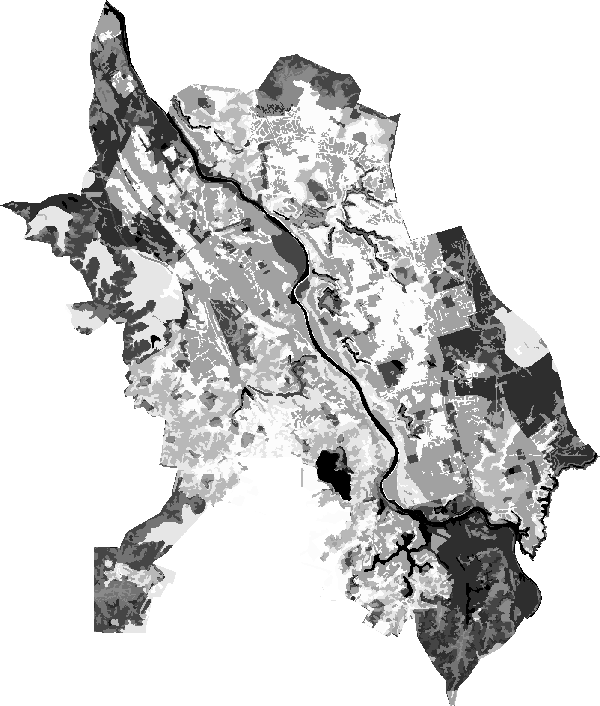

In [15]:
# 3 Merge the soil and landcover weight layers to one final weight layer
final_weight = merge_weights(soil_weight, landcover_weight, "final_weight.tif")

# Display the final weight layer
final_weight

<h1>3. Hydrological analysis</h1>

<h3>3.1 Generate the fill, flow direction, flow accumulation layers</h3>

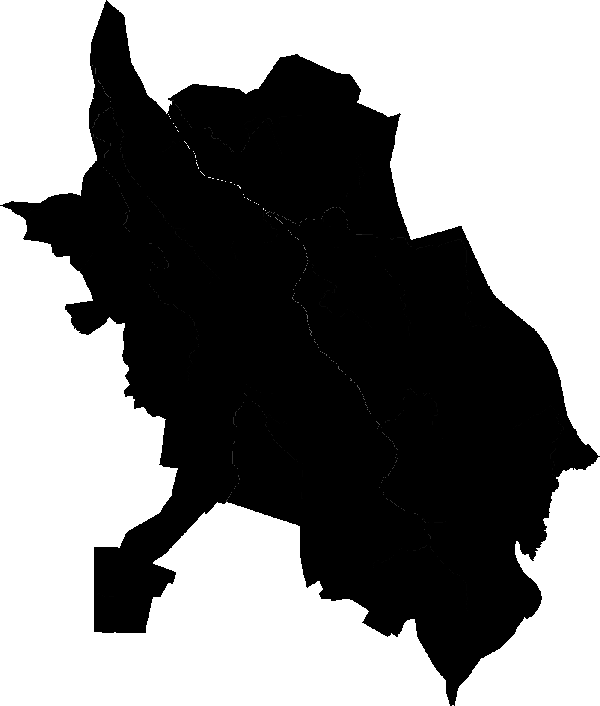

In [16]:
# Step 1: Fill sinks, and save the file to disk 
filled_dem = Fill("clipped_DEM.tif")
filled_dem.save("filled_DEM.tif")

# Step 2: Flow Direction, and save the file to disk  
flow_dir = FlowDirection(filled_dem)
flow_dir.save("flow_direction.tif")

# Step 3: Flow Accumulation (use the final weight layer), and save the file to disk 
flow_acc = FlowAccumulation(flow_dir, final_weight)
flow_acc.save("flow_accumulation.tif")
flow_acc # Display the flow accumulation layer

<h3>3.2 Generate flood depth, connected flood area, and contour layers</h3>

In [17]:
# Step 1: Function that generates flood depth raster based on flow accumulation, DEM, and rainfall depth.
#         Also set extreme values to the 90th percentile (PCT_90) threshold value.
#         Also remove areas with no water depth (depth <= 0 meter).
def generate_flood_depth(flow_acc_raster, dem_raster, rainfall_m, output_tag):

    # Parameters:
    # - flow_acc_raster : Flow accumulation raster
    # - dem_raster: DEM raster
    # - rainfall_m: Rainfall amount in "meter"
    # - output_tag (str): Tag used to name the output files (e.g., "50mm")

    # 1> Estimate the accumulated rainfall per unit grid by multiplying the flow accumulation by the rainfall depth
    rainfall_acc = rainfall_m * flow_acc_raster

    # 2> Add the accumulated rainfall to the DEM to get the "temporary water surface height" 
    surface_depth = rainfall_acc + dem_raster

    # 3> Subtract DEM from the surface water height to get the water depth
    # If it is less than or equal to 0, there is no flooding (use Con to assign NoData)
    inundation_depth = Con(surface_depth - dem_raster > 0, surface_depth - dem_raster)

    # 4> Save the original depth layer
    inundation_depth.save(f"inun_depth_{output_tag}.tif") 

    # 5> Convert the raster to a NumPy array for statistical analysis (excluding NoData)
    arr = arcpy.RasterToNumPyArray(inundation_depth, nodata_to_value=np.nan)

    # 6> Calculate the 90% quantile of water depth (PCT_90) to eliminate abnormally large values
    pct_90 = round(np.nanpercentile(arr, 90), 2)
    print(f"{output_tag} - PCT_90: {pct_90}") # Print notifications

    # 7> Use the Con statement to replace pixels greater than PCT_90 with PCT_90 (limit extreme values)
    flood_depth = Con(inundation_depth > pct_90, pct_90, inundation_depth)

    # 8> Save the final processed water depth layer
    flood_depth_path = f"flood_depth_{output_tag}.tif"
    flood_depth.save(flood_depth_path)
    
    print(f"Saved flood depth: {flood_depth_path}") # Print notifications
    
    # 9> Returns the result layer path for subsequent use
    return flood_depth_path

In [18]:
# Step 2: Function that smooth the flood depth raster to simulate natural water spread.
#         Also removes shallow areas (< 0.1m) after smoothing.
def apply_focal_smoothing(input_raster_path, radius, stat_type, output_tag):

    # Parameters:
    # - input_raster_path: Path to the input flood depth raster
    # - radius: Radius (in cells) for the neighborhood (e.g., 3 or 5)
    # - stat_type: Type of smoothing statistic (e.g., "MEAN", "MEDIAN")
    # - output_tag: Custom tag used to name the output file

    # 1> Read the input water depth layer (convert from path to Raster object)
    raster = Raster(input_raster_path)

    # 2> Create a circular neighborhood and specify the radius (in cell)
    neighborhood = NbrCircle(radius, "CELL")

    # 3> Use Focal Statistics for smoothing the depth layer
    smoothed = FocalStatistics(
        in_raster=raster,
        neighborhood=neighborhood,
        statistics_type=stat_type,
        ignore_nodata="DATA"  # Ignore NoData values, and only calculate valid data
    )

    # 4> Remove the areas with water depth less than 0.1m in the smoothed result
    smoothed = Con(smoothed >= 0.1, smoothed)

    # 5> Build the output file name with the smoothing radius and method markers
    smooth_path = f"{output_tag}_smooth_r{radius}_{stat_type.lower()}.tif"

    # 6> Save the smoothed layer
    smoothed.save(smooth_path)
    
    print(f"Smoothed raster saved: {smooth_path}")  # Print notifications

    # 7> Return the output file path for subsequent calls
    return smooth_path

In [19]:
# Step 3: Function that use Region Group + RasterToPolygon + area filter + PolygonToRaster to extract connected areas with an area greater than 1000 sqm 
#         to represent the selected inundation area.
#         Add return the result as a mask. 
def extract_connected_regions(input_raster_path, output_tag, area_thresh=1000, cell_size=10):
    
    # Parameters:
    # - input_raster_path: Input depth layer path
    # - output_tag: Tags used in output file names (e.g. '50mm')
    # - area_thresh: Minimum reserved area, in square meters, default is 1000
    # - cell_size: The cell size of the raster output, in meters

    # 1> Generate a region group layer    
    input_raster = Int(Raster(input_raster_path))  # Convert to integer raster (satisfies RegionGroup requirements)    
    region_raster = RegionGroup(input_raster, "EIGHT", "WITHIN", "NO_LINK")  # Region Group Analysis (use Eight-neighborhood connectivity)    
    region_raster_path = f"region_raw_{output_tag}.tif"
    region_raster.save(region_raster_path)  # Save the original region group layer

    # 2> Convert Raster to Polygon（Used to calculate areas for each zone in region group layer）
    region_polygon = f"region_{output_tag}_polygon.shp"  # Name the outputfile
    arcpy.RasterToPolygon_conversion(region_raster, region_polygon, "NO_SIMPLIFY", "Value")  # Performe conversion operations

    # 3> Calculate the area of each region (AddField + CalculateGeometryAttributes)
    arcpy.AddField_management(region_polygon, "Area_m2", "DOUBLE")  # Add a new field Area_m2 to store the area of each polygon
    arcpy.CalculateGeometryAttributes_management(region_polygon, [["Area_m2", "AREA"]], area_unit="SQUARE_METERS") # Use CalculateGeometryAttributes to calculate aread in square meters

    # 4> Select areas with an area greater than a threshold
    region_selected = f"region_{output_tag}_selected.shp"
    arcpy.Select_analysis(region_polygon, region_selected, f'"Area_m2" >= {area_thresh}')

    # 5> Convert back to Raster (used to mask)
    region_mask_raster = f"region_{output_tag}.tif"
    arcpy.PolygonToRaster_conversion(
        in_features=region_selected,
        value_field="FID",
        out_rasterdataset=region_mask_raster,
        cell_assignment="MAXIMUM_AREA",
        cellsize=cell_size
    )

    print(f"Region-filtered raster saved: {region_mask_raster}")

    # 6> Return a cleaned mask raster layer
    return region_mask_raster  


In [20]:
# Step 4: Function that use the region_mask_raster as a mask to extract the flood depth layer and generate contours with 0.5m intervals
def mask_and_generate_contour(region_raster_path, depth_raster_path, output_tag, contour_interval=0.5):

    # Parameters:
    #     region_raster_path: Path to the filtered raster layer
    #     depth_raster_path: Smoothed depth layer path
    #     output_tag: Tags used for output file naming
    #     contour_interval: The interval of the contour lines

    # 1> Read the area mask and water depth layer
    region_raster = Raster(region_raster_path)
    depth_raster = Raster(depth_raster_path)

    # 2> Use the SetNull function to extract the mask:
    # If region_raster is Null (does not belong to the target area), the result is Null, otherwise the corresponding water depth value is retained
    masked = SetNull(IsNull(region_raster), depth_raster)

    # 3> Save the masked water depth layer
    masked_path = f"depth_{output_tag}_masked.tif"
    masked.save(masked_path)

    # 4> Generate contour vector layer
    contour_path = f"contour_{output_tag}.shp"
    Contour(masked_path, contour_path, contour_interval)
    
    print(f"Contour saved: {contour_path}")
    # 5> Return the path to the contour file
    return contour_path

In [21]:
# Step 5: Read and display the rainfall data file by using Pandas library
df = pd.read_csv(input_dir + r"Rainfall\rainfall.csv")
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
df  # Display

,Rainfall depths (mm) :: Historical Data,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,ARI,AEP,10m,20m,30m,1h,2h,6h,12h,24h,48h,72h,96h,120h
1,1.58,0.633,8.98,12.5,15,20.2,26.7,39.9,50.1,61.6,74.3,82.2,87.9,92.3
2,2,0.5,9.84,13.7,16.4,22.1,29.2,43.6,54.7,67.3,81.1,89.6,95.8,101
3,5,0.2,12.9,17.9,21.4,28.8,38,56.5,70.8,86.9,105,115,123,129
4,10,0.1,15.2,21.1,25.3,33.9,44.7,66.3,82.9,102,122,135,144,151
5,20,0.05,17.6,24.4,29.3,39.3,51.7,76.6,95.7,117,141,155,165,174
6,30,0.033,19.2,26.5,31.8,42.6,56,82.9,103,127,152,167,179,187
7,40,0.025,20.3,28,33.6,45,59.1,87.5,109,133,160,176,188,197
8,50,0.02,21.2,29.2,35,46.9,61.6,91.1,114,139,167,183,196,205
9,60,0.017,21.9,30.2,36.2,48.5,63.7,94.1,117,143,172,189,202,212


In [22]:
# Step 6: Determine the rainfall data scenarios, and call the above functions to generate the final water depth layer, contour layer.

# 1> Rainfall data scenarios: Select the 1-hour values corresponding to 10, 20, and 50 years in Historical Data as rainfall data (33.9, 39.3, and 46.9 mm/h respectively)
rainfall_scenarios = {
    "10yr": 0.0339,
    "20yr": 0.0393,
    "50yr": 0.0469
}

# 2> Traverse each rainfall scenario, and call the above functiongs step by step
for tag, rainfall_m in rainfall_scenarios.items():

    # Generate the original flood depth layer, and remove the extreme values
    flood_path = generate_flood_depth(flow_acc, dem_clipped, rainfall_m, tag)

    # Smooth depth layers
    for radius, stat_type in [(3, "MEAN"), (3, "MEDIAN"), (5, "MEAN"), (5, "MEDIAN")]:  # Use four conditions in focal statistics analysis

        # Generate smoothed flood depth layer, and get the path
        smooth_path = apply_focal_smoothing(flood_path, radius, stat_type, tag)

        # Extract connected regions (Region Group) with an area > 1000㎡ from the smoothed layer
        region_path = extract_connected_regions(smooth_path, f"{tag}_r{radius}_{stat_type.lower()}")

        # Use the selected connected areas to mask the original layer and generate contour lines (contour lines)
        mask_and_generate_contour(region_path, smooth_path, f"{tag}_r{radius}_{stat_type.lower()}")

10yr - PCT_90: 2.14
Saved flood depth: flood_depth_10yr.tif
Smoothed raster saved: 10yr_smooth_r3_mean.tif
Region-filtered raster saved: region_10yr_r3_mean.tif
Contour saved: contour_10yr_r3_mean.shp
Smoothed raster saved: 10yr_smooth_r3_median.tif
Region-filtered raster saved: region_10yr_r3_median.tif
Contour saved: contour_10yr_r3_median.shp
Smoothed raster saved: 10yr_smooth_r5_mean.tif
Region-filtered raster saved: region_10yr_r5_mean.tif
Contour saved: contour_10yr_r5_mean.shp
Smoothed raster saved: 10yr_smooth_r5_median.tif
Region-filtered raster saved: region_10yr_r5_median.tif
Contour saved: contour_10yr_r5_median.shp
20yr - PCT_90: 2.48
Saved flood depth: flood_depth_20yr.tif
Smoothed raster saved: 20yr_smooth_r3_mean.tif
Region-filtered raster saved: region_20yr_r3_mean.tif
Contour saved: contour_20yr_r3_mean.shp
Smoothed raster saved: 20yr_smooth_r3_median.tif
Region-filtered raster saved: region_20yr_r3_median.tif
Contour saved: contour_20yr_r3_median.shp
Smoothed raster 

<h3>3.3 Generate the selected shelter areas</h3>

<AxesSubplot: >

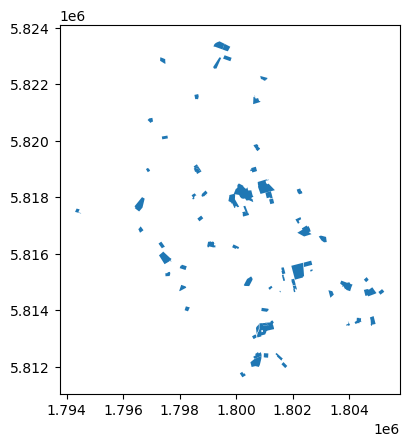

In [23]:
# Step 1: Clip the facilities (include the areas of schools and hospitals) shapefile to Hamilton City boundary
original_facilities = input_dir + r"facilities\nz-facilities.shp"  # Path to the original facilities file
arcpy.Clip_analysis(original_facilities, hamilton_boundary, "facilities_clipped.shp")  # Clip the facilities layer

# Load and display the clipped facilities shapefile
gdf_facilities = gpd.read_file(r"C:\GisData\538_Output\facilities_clipped.shp")
gdf_facilities.plot()

In [24]:
# Step 2: Loop through all selected inundation areas (i.e., the "region_selected" shapefiles from Step 3.2)
for tag in rainfall_scenarios:
    for radius, stat_type in [(3, "MEAN"), (3, "MEDIAN"), (5, "MEAN"), (5, "MEDIAN")]:
        
        # Path to the selected inundation areas (i.e., "region_selected")
        region_selected = f"region_{tag}_r{radius}_{stat_type.lower()}_selected.shp"

        # Build the output file's name
        output_shp = f"facilities_safe_{tag}_r{radius}_{stat_type.lower()}.shp"

        # Perform the "Erase" operation to remove areas within the inundation zones
        arcpy.Erase_analysis(
            in_features="facilities_clipped.shp",
            erase_features=region_selected,
            out_feature_class=output_shp
        )

        print(f"Shelter saved: {output_shp}")

Shelter saved: facilities_safe_10yr_r3_mean.shp
Shelter saved: facilities_safe_10yr_r3_median.shp
Shelter saved: facilities_safe_10yr_r5_mean.shp
Shelter saved: facilities_safe_10yr_r5_median.shp
Shelter saved: facilities_safe_20yr_r3_mean.shp
Shelter saved: facilities_safe_20yr_r3_median.shp
Shelter saved: facilities_safe_20yr_r5_mean.shp
Shelter saved: facilities_safe_20yr_r5_median.shp
Shelter saved: facilities_safe_50yr_r3_mean.shp
Shelter saved: facilities_safe_50yr_r3_median.shp
Shelter saved: facilities_safe_50yr_r5_mean.shp
Shelter saved: facilities_safe_50yr_r5_median.shp


<h3>3.4 Extract the data for each masked water depth layer</h3>

In [25]:
# Step 1: Function that perform "zonal statistics" on the masked water depth layer according to the selected regional layer 
# (the corresponding variables' name: masked_path, region_selected)
def summarize_flood_stats(region_shp, masked_depth_raster, tag, radius, stat_type, results):
    # Parameters:
    # region_shp：Path to the selected region vector layer
    # masked_depth_raster：Path to the masked water depth raster layer
    # tag：Rainfall Scenarios Tags（e.g., "10yr"）
    # radius：The neighborhood radius used by Focal Statistics
    # stat_type：Focal Statistics statistical method ("MEAN" or "MEDIAN")
    # results：A list to collect the results of each statistic
    
    # 1> Add an area field and calculate the area of each region (in square meters)
    arcpy.AddField_management(region_shp, "Area_m2", "DOUBLE")  # Add the Area_m2 field (if the field already exists, this statement will be ignored)
    arcpy.CalculateGeometryAttributes_management(region_shp, [["Area_m2", "AREA"]], area_unit="SQUARE_METERS")  # Calculate the area of each region and write it to the Area_m2 field

    # 2> Calculating the total area and number of regions
    # Use SearchCursor to read all area values
    with arcpy.da.SearchCursor(region_shp, ["Area_m2"]) as cursor:
        area_list = [row[0] for row in cursor]  # Extract the area of all regions
        total_area = round(sum(area_list), 2)  # Total area (square meters)
        region_count = len(area_list)  # Total number of areas

    # 3> Execute Zonal Statistics to write the water depth statistics of each zone into a table
    zonal_table = f"zonal_{tag}_r{radius}_{stat_type.lower()}.dbf"  # Build the output table file name
    arcpy.sa.ZonalStatisticsAsTable(  #Perform regional statistical analysis and partition by FID in each region
        in_zone_data=region_shp,
        zone_field="FID",
        in_value_raster=masked_depth_raster,
        out_table=zonal_table,
        statistics_type="ALL",
        ignore_nodata="DATA"
    )

    # 4> Read the average water depth and maximum water depth from the statistics table
    df_zone = pd.DataFrame(arcpy.da.TableToNumPyArray(zonal_table, ["MEAN", "MAX"]))  # Use TableToNumPyArray to convert the statistical table to DataFrame

    # Calculate the average water depth and the maximum water depth of all areas
    avg_depth = round(df_zone["MEAN"].mean(), 2)
    max_depth = round(df_zone["MAX"].max(), 2)

    # 5> Add analysis results to the results list
    results.append({
        "Rainfall_Scenario": tag,
        "Radius": radius,
        "Stat_Type": stat_type.upper(),
        "Total_Area_m2": total_area,
        "Region_Count": region_count,
        "Avg_Depth_m": avg_depth,
        "Max_Depth_m": max_depth
    })

In [26]:
# Step 2: Perform the statistical operation
# 1> Initialize an empty list to save statistical results
summary_results = []

# 2> Traverse all rainfall scenarios and 4 Focal Statistics combinations
for tag in rainfall_scenarios:
    for radius, stat_type in [(3, "MEAN"), (3, "MEDIAN"), (5, "MEAN"), (5, "MEDIAN")]:

        # Path to selected region shapfile
        region_shp = f"region_{tag}_r{radius}_{stat_type.lower()}_selected.shp"

        # Path to masked water depth file
        masked_depth_raster = f"depth_{tag}_r{radius}_{stat_type.lower()}_masked.tif"

        # Call the statistical function
        summarize_flood_stats(region_shp, masked_depth_raster, tag, radius, stat_type, summary_results)

# 3> Convert the results to a CSV table and save it
df_summary = pd.DataFrame(summary_results)
df_summary.to_csv(r"C:\GisData\538_Output\flood_summary.csv", index=False)
print("Completed Statistics，Saved as: flood_summary.csv")

Completed Statistics，Saved as: flood_summary.csv
